# Ajuste del ábaco de caudales de avenida del P.H. Norte II
***

__Autor__: Marco Antonio Pérez, Jesús Casado<br>
__Organización__: Tragsatec<br>
__Fecha__: 9-feb-2021<br>

__Introducción__:<br>
En la siguiente figura se muestra el ábaco definido en el Plan Hidrológico Norte II para el cáculo del caudal de avenida en función del área vertiente al punto de cálculo y del periodo de retorno.
<img src="Avenida máxima probable. P.H. Norte II.jpg">

Se nos entregó una formulación de este ábaco aplicable a periodos de retorno entre 5 y 50 años:

$$ Q = 3.5465 \cdot T^{0.208} \cdot S^{0.7727 - 0.0315 \cdot \log_{10} T}$$

__Enlaces relacionados__:<br>
[Fit surface to polynomials in Python](https://gist.github.com/amroamroamro/1db8d69b4b65e8bc66a6)

In [21]:
import numpy as np
import pandas as pd
from scipy import optimize
import scipy.linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()

## 1 Datos del ábaco
Se cargan puntos extraídos de la figura del ábaco.

In [22]:
# importo el ábaco del excel
abaco = pd.read_excel('abaco.xlsx', sheet_name='abaco', index_col='S')
abaco.columns = [int(x[1:]) for x in abaco.columns]

In [23]:
abaco

,5,10,25,50,100,500
S,,,,,,
100,1.60000,1.719998,1.950000,2.200000,4.00000,6.26999
200,1.59407,1.713566,1.942563,2.191558,3.98392,6.24438
300,1.58814,1.707134,1.935126,2.183116,3.96784,6.21877
400,1.58221,1.700702,1.927689,2.174674,3.95176,6.19316
500,1.57628,1.694270,1.920252,2.166232,3.93568,6.16755
...,...,...,...,...,...,...
19600,0.44365,0.465758,0.499785,0.553810,0.86440,1.27604
19700,0.43772,0.459326,0.492348,0.545368,0.84832,1.25043
19800,0.43179,0.452894,0.484911,0.536926,0.83224,1.22482


In [24]:
data

[]

In [25]:
# reordenar los datos en una matriz de 3 columnas
TT, SS = np.meshgrid(abaco.columns, abaco.index)
data = np.vstack((TT.flatten(), SS.flatten(), abaco.values.flatten())).T
data = pd.DataFrame(data, columns=['T', 'S', 'Qs'])

In [26]:
data

,T,S,Qs
0,5.0,100.0,1.600000
1,10.0,100.0,1.719998
2,25.0,100.0,1.950000
3,50.0,100.0,2.200000
4,100.0,100.0,4.000000
...,...,...,...
1195,10.0,20000.0,0.440030
1196,25.0,20000.0,0.470037
1197,50.0,20000.0,0.520042
1198,100.0,20000.0,0.800080


## 2 Expresión analítica CHC

Se analiza el funcionamiento de la expresión analítica proporcionada por la Confederación con respecto a los datos del ábaco.

### Calcular caudal
Dadas la superficie y el periodo de retorno

In [27]:
a = 3.5465
b = 0.208
c = 0.7727
d = -0.10315

def QfromTS_CHC(T, S, a=3.5465, b=0.208, c=0.7727, d=-0.0315):
    """Calcula el caudal en base al periodo de retorno y la superficie:
    
            Q = a * T^b * S^[c + d * log(T)]
    
    Entradas:
    ---------
    T:          float o array (n,). Periodo de retorno (años)
    S:          float o array (n,). Superficie (km2)
    a, b, c, d: float. Parámetros de la ecuación
    
    Salida:
    -------
    Q:          float o array (n,). Caudal (m3/s)"""
    
    Q = a * T**b * S**(c + d * np.log10(T))
    
    return Q

In [28]:
# Prueba con un T y una superficie cualquiera
T = 10 # años
S = 1174 # km²

# Aplico la fórmula
Q = QfromTS_CHC(T, S)
print('Q = {0:.1f} m³/s'.format(Q))

Q = 1079.0 m³/s


In [29]:
# extraer vectores de periodo de retorno y superficie
T = data['T'].values # años
S = data['S'].values # km²

# caudal asociado
Q = QfromTS_CHC(T, S)

# reordenar en un dataframe similar a 'abaco'
fCHC = pd.DataFrame(Q.reshape(abaco.shape), index=abaco.index, columns=abaco.columns)

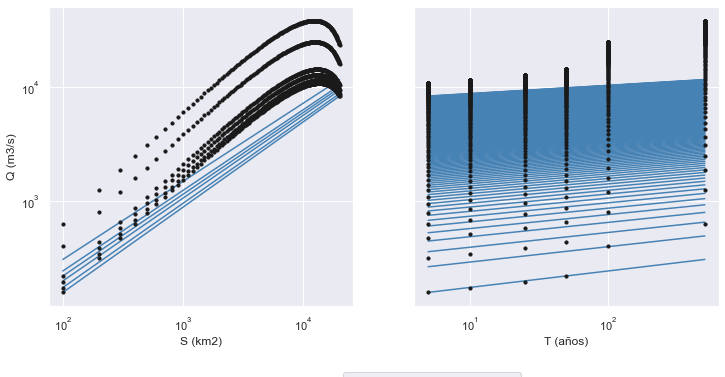

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5.5), sharey=True)

for T in fCHC.columns:
    ax[0].plot(fCHC.index, fCHC[T], c='steelblue', label='ajuste CHC', zorder=1)
    ax[0].scatter(abaco.index, abaco[T] * abaco.index, s=10, c='k', label='abaco', zorder=2)
    ax[0].set(xscale='log', yscale='log', xlabel='S (km2)', ylabel='Q (m3/s)')

for S in fCHC.index:
    ax[1].plot(fCHC.columns, fCHC.loc[S,:], c='steelblue', label='ajuste CHC', zorder=1)
    ax[1].scatter(abaco.columns, abaco.loc[S,:] * S, s=10, c='k', label='abaco', zorder=2)
    ax[1].set(xscale='log', yscale='log', xlabel='T (años)');
    
handles, labels = ax[1].get_legend_handles_labels()
labels = [labels[i] for i in [0, -1]]
handles = [handles[i] for i in [0, -1]]
fig.legend(handles, labels, loc=8, ncol=2, bbox_to_anchor=[0.35, -0.05, .3, .1]);

El ajuste es un plano cuando se transforman las tres variables a escala logarítmica. Este ajuste es relativamente bueno para retornos bajos y superficies medias-altas.

### Calcular periodo de retorno
Dadas la superficie y el caudal, calcular el periodo de retorno asociado. El problema consiste en encontrar la raíz de la ecuación:
$$ 3.5465 \cdot T^{0.208} \cdot S^{0.7727 - 0.0315 \cdot \log_{10} T} - Q = 0$$

Compruebo que se obtiene el retorno utilizado más arriba para calcular el caudal a partir de retorno y superficie.

__Método de Brent__

In [31]:
S, Q = 1174, 1079.0

def fCHC(T, S=S, Q=Q, a=3.5465, b=0.208, c=0.7727, d=-0.0315):
    return round(a * T**b * S**(c + d * np.log10(T)) - Q, 1)

# calcular retorno por el método de Brent
Tbrent = optimize.root_scalar(fCHC, bracket=[0.001, 2000], method='brentq').root
print('Brent:\tT = {0:.1f} años'.format(Tbrent))

Brent:	T = 10.0 años


__Método de Newton-Raphson__<br>
Requiere la derivada de la función cuya raíz se quiere calcular.

In [32]:
S, Q = 1174, 1079.0

# Hago la derivada que me servirá para encontrar las raices del polinomio según el metodo de Newton-Raphson
def fCHCprime(T, S=S, Q=Q, a=3.5465, b=0.208, c=0.7727, d=-0.0315):
    return a * b * T**(b-1) * S**(c - d * np.log10(T)) + a * T**b * (d / (np.log(10) * T)) * S**(c +d * np.log10(T) - 1)

# calcular retorno por el método de Newton
Tnewton = optimize.root_scalar(fCHC, x0=10, fprime=fCHCprime, method='newton').root
print('Newton:\tT = {0:.1f} años'.format(Tnewton))

Newton:	T = 10.0 años


El código es correcto puesto que se obtiene el periodo de retorno adecuado.
## 3 Ajuste propio
### Regresión lineal $\log Q_s-\log S$
Se ajusta, independientemente para cada periodo de retorno, la siguiente regresión lineal:
$$\log_{10} Q_s = a \cdot \log_{10} S + b$$
Posteriormente se calculan los puntos de la tabla _abaco_ según las rectas ajustadas para analizar el grado de ajuste.

In [33]:
# ajustar rectas para cada periodo de retorno
Pars = pd.DataFrame(index=['a', 'b'], columns=abaco.columns)
for T in abaco.columns:
    # ajustar polinomio para un periodo de retorno 
    Pars[T] = np.polyfit(np.log10(abaco.index), np.log10(abaco[T]), deg=1)
    
Pars

,5,10,25,50,100,500
a,-0.320324,-0.325425,-0.337133,-0.340922,-0.372268,-0.384194
b,1.217330,1.265293,1.357847,1.422560,1.784415,2.018625


In [34]:
# calcular puntos de la curva ajustada
ajuste = pd.DataFrame(index=abaco.index, columns=Pars.columns)
for T in Pars.columns:
    # np.polyval(pars, x). If x is a sequence, then p(x) is returned for each element of x.
    ajuste[T] = 10**np.polyval(Pars[T], np.log10(abaco.index))
ajuste = ajuste.round(2)

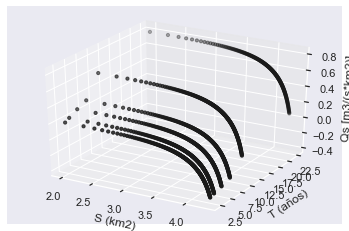

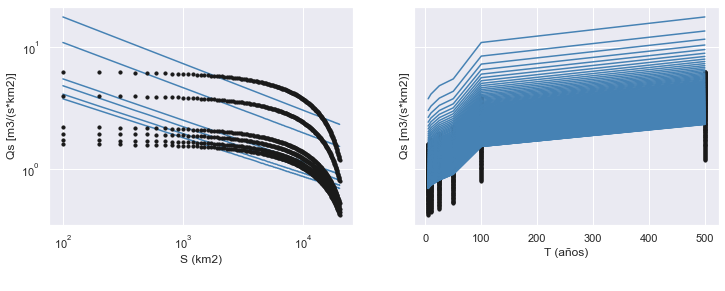

In [35]:
# plot points and fitted surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(np.log10(data['S']), np.sqrt(data['T']), np.log10(data['Qs']), c='k', s=10)
ax.set(xlabel='S (km2)', ylabel='T (años)', zlabel='Qs [m3/(s*km2)]')
#ax.axis('tight');

fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

# gráfico Q vs S
for T in abaco.columns:
    ax[0].plot(ajuste.index, ajuste[T], c='steelblue', label='ajuste', zorder=1)
    ax[0].scatter(abaco.index, abaco[T], s=10, c='k', label='abaco', zorder=2)
ax[0].set(xscale='log', yscale='log', xlabel='S (km2)', ylabel='Qs [m3/(s*km2)]');

S = 100
# gráfico Q vs T
for S in abaco.index:
    ax[1].scatter(abaco.columns, abaco.loc[S,:], s=10, c='k', label='abaco', zorder=2)
    ax[1].plot(ajuste.columns, ajuste.loc[S,:], c='steelblue', label='ajuste', zorder=2)
ax[1].set(xlabel='T (años)', ylabel='Qs [m3/(s*km2)]');

# leyenda
handles, labels = ax[1].get_legend_handles_labels()
handles = [handles[i] for i in [0, -1]]
labels = [labels[i] for i in [0, -1]]
fig.legend(handles, labels, loc=8, ncol=2, bbox_to_anchor=[0.35, -.1, .3, .1]);

El gráfico de la función entre $Q_s$  y $S$ a rectas es muy bueno. 

### Ajuste de la relación $Q_s - T$
El problema es encontrar una función de dos variables que relacione el caudal específico con la superficie de cuenca y el periodo de retorno simultáneamente. En el gráfico superior se muestran los puntos del ábaco en un espacio 3D con las tres variables. Se intuye que en el plato $Qs-S$ la relación es lineal, como se comprueba en el gráfico inferior izquierdo. Por el contrario, en el plano $Qs-T$ no es así; el gráfico inferior derecho muestra una relación potencialmente cuadrática ($log_{10}^2 Q_s = c \cdot T$). Por tanto, sería necesario ajustar un función de dos variables de grado 2 a los puntos del ábaco. Para simplificar este cálculo, se puede buscar una transformación de los valores de $T$ que linearice la relación entre $Q_s$ y $T$, similar a la transformación logarítmica utilizada para que la relación entre $Q_s$ y $S$ sea lineal. Encontrada esa transformación, los puntos del ábaco se aproximarían a un plano en el espacio 3D y se podría ajustar una función de dos variables de grado 1.

__Transformaciones de T__

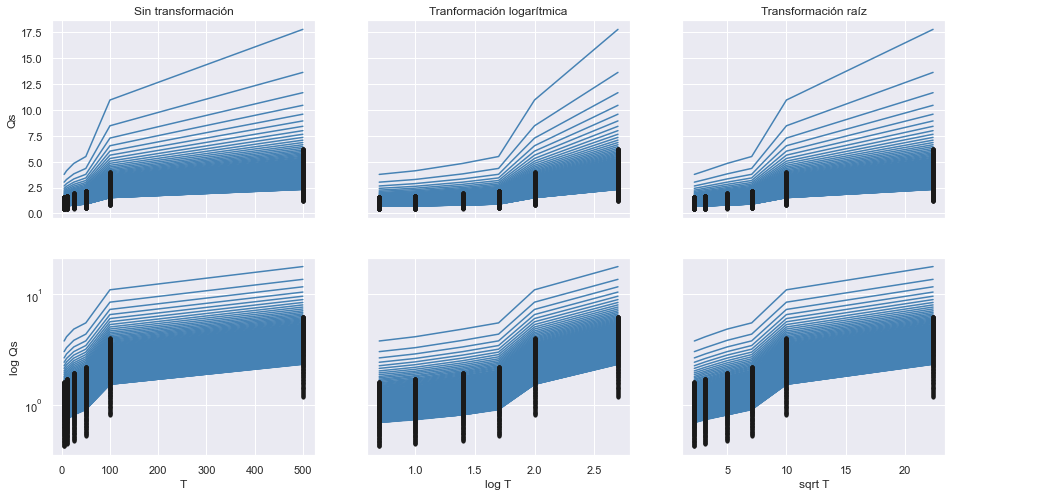

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))#, sharey=True)#, sharex=True)

for S in abaco.index:
    for r in [0,1]:
        ax[r,0].scatter(abaco.columns, abaco.loc[S,:], s=10, c='k', label='abaco', zorder=2)
        ax[r,0].plot(ajuste.columns, ajuste.loc[S,:], c='steelblue', label='ajuste', zorder=1)
        if r == 0:
            ax[r,0].set(title='Sin transformación', ylabel='Qs', yscale='linear')
            ax[r,0].set_xticklabels([])
        elif r == 1:
            ax[r,0].set(xlabel='T', ylabel='log Qs', yscale='log')

        ax[r,1].scatter(np.log10(abaco.columns), abaco.loc[S,:], s=10, c='k', label='abaco', zorder=2)
        ax[r,1].plot(np.log10(ajuste.columns), ajuste.loc[S,:], c='steelblue', label='ajuste', zorder=1)
        if r == 0:
            ax[r,1].set(title='Tranformación logarítmica')
            ax[r,1].set_xticklabels([])
        elif r == 1:
            ax[r,1].set(xlabel='log T', yscale='log')#, ylabel='Qs')
        ax[r,1].set_yticklabels([])


        ax[r,2].scatter(np.sqrt(abaco.columns), abaco.loc[S,:], s=10, c='k', label='abaco', zorder=2)
        ax[r,2].plot(np.sqrt(ajuste.columns), ajuste.loc[S,:], c='steelblue', label='ajuste', zorder=1)
        if r == 0:
            ax[r,2].set_title('Transformación raíz')
            ax[r,2].set_xticklabels([])
        elif r == 1:
            ax[r,2].set(xlabel='sqrt T', yscale='log')#, ylabel='Qs')
        ax[r,2].set_yticklabels([])
        
# leyenda
handles, labels = ax[1,2].get_legend_handles_labels()
handles = [handles[i] for i in [0, -1]]
labels = [labels[i] for i in [0, -1]]
fig.legend(handles, labels, loc=5, bbox_to_anchor=[0.9, .35, .1, .3]);

En los gráficos superiores se muestran combinaciones de transformaciones de los datos de $Q_s$ y $T$ con la intención de encontrar aquella transformación que linealice la relación entre estas dos variables.

A simple vista parece que sólo dos combinaciones tienen una relación aproximadamente lineal: $Q_s$-$\sqrt T$ y $\log Q_s$-$\sqrt T$. La primera de ellas aparenta una mayor linelidad que la segunda, pero tiene la desventaja de que $Q_s$ ya tiene que ser transformada logarítmicamente para calcular su regresión con la superficie. En ambos casos la relación deja de ser lineal para superficies pequeñas (las líneas con mayor $Q_s$).

 ## 4 Ajuste de una función lineal de dos variables
 
Se ajusta la función del caudal específico en base a dos variables: superficie y periodo de retorno. Para que esta función sea lineal, primero se transforman los datos del ábaco: logaritmos para el caudal y la superficie, y la raíz cuadrada para el periodo de retorno.

In [37]:
# crea un array con los datos transformados
dataTransf = data.copy()
dataTransf['T'] = np.sqrt(data['T'])
dataTransf['S'] = np.log10(data['S'])
dataTransf['Qs'] = np.log10(data['Qs'])

In [40]:
dataTransf

,T,S,Qs
0,2.236068,2.00000,0.204120
1,3.162278,2.00000,0.235528
2,5.000000,2.00000,0.290035
3,7.071068,2.00000,0.342423
4,10.000000,2.00000,0.602060
...,...,...,...
1195,3.162278,4.30103,-0.356518
1196,5.000000,4.30103,-0.327868
1197,7.071068,4.30103,-0.283962
1198,10.000000,4.30103,-0.096867


In [38]:
# regular grid covering the domain of the data
XX,YY = np.meshgrid(np.array(np.sqrt([5, 10, 25, 50, 100, 500])), np.arange(np.log10(10), np.log10(50000), .5))
X = XX.flatten()
Y = YY.flatten()

In [42]:
order = 2   # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane: Z = a·X + b·Y + c
    A = np.c_[dataTransf['T'].values, dataTransf['S'].values, np.ones(dataTransf.shape[0])]
    pars, residues, rank, s = scipy.linalg.lstsq(A, dataTransf['Qs'].values)    # coefficients
    
    # evaluate it on grid
    a, b, c = pars
    ZZ = a * XX + b * YY + c
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve: Z = a + b·X + c·Y + d·X·Y + e·X² + f·Y²
    A = np.c_[np.ones(dataTransf.shape[0]), data.loc[:,['T', 'S']], np.prod(data.loc[:,['T', 'S']], axis=1), dataTransf.loc[:,['T', 'S']]**2]
    pars, residues, rank, s = scipy.linalg.lstsq(A, dataTransf['Qs'].values)
   
    # evaluate it on a grid
    a, b, c, d, e, f = pars
    ZZ = np.dot(np.c_[np.ones(X.shape), X, Y, X*Y, X**2, Y**2], pars).reshape(XX.shape)

In [43]:
pars

array([ 1.22568791e-01,  5.68013799e-04, -3.84841320e-05, -1.03219642e-08,
        5.68013800e-04,  2.06267516e-02])

In [49]:
def QfromTS(T, S, pars, deg=2):
    """Calcula el caudal específico asociado a una superficie de cuenca y un periodo de retorno. 
    
    Si la ecuación es de grado 1:
            log10(Q/S) = a * sqrt(T) + b * log10(S) + c
            
    Si la ecuación es de grado 2:
          log10(Q/S) = a  +  b *sqrt(T)^2 + c * log10(S)^2
            
    Entradas:
    ---------
    S:       float or array (n,). Superficie (km2)
    T:       float or array (n,). Periodo de retorno (años)
    pars:    array. Parámetros de la ecuación
    deg:     int. Grado de la ecuación: 1 ó 2
    
    Salidas:
    --------
    Qs:     float or array (n,). Caudal específico [m3/(s*km2)]
    """
    
    Ttrans = np.sqrt(T)
    Strans = np.log10(S)

    if deg == 1:
        if len(pars) != 3:
            return print('ERROR. Número de parámetros erróneos.')
        Qtrans = pars[0] * Ttrans + pars[1] *  Strans + pars[2]
    
    if deg == 2:
        if len(pars) != 6:
            return print('ERROR. Número de parámetros erróneos.')
        Qtrans = a + b * Ttrans + c * Strans + d * Ttrans * Strans + e * Ttrans**2 + f * Strans**2
        
    Qs = 10**Qtrans
    Q = Qs * S
    return Q

#def QfromST(S, T, a, e, f):
#    Slog = np.log10(S)
#    Tlog = np.log10(T)
#    Qlog = np.log10(Q)
    
#    return 10**(a + e * Slog**2 + f * Tlog**2)

def TfromSQ(S, Q, pars):
    """"""
    Qtrans = np.log10(Q / S)
    Strans = np.log10(S)
    
    a, b, c = pars
    return ((Qtrans - b * Strans - c) / a)**2

In [50]:
pars

array([ 1.22568791e-01,  5.68013799e-04, -3.84841320e-05, -1.03219642e-08,
        5.68013800e-04,  2.06267516e-02])

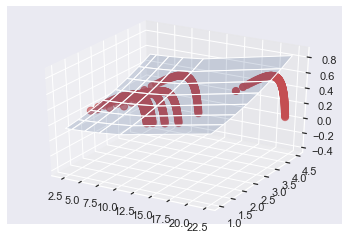

In [54]:
# plot points and fitted surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, alpha=0.2)
ax.scatter(dataTransf['T'], dataTransf['S'], dataTransf['Qs'], c='r', s=50)
# ax.axis('equal')
ax.axis('tight')
plt.show()

In [55]:
# caudal asociado
Ts = np.array([.1, .5, 1, 2, 5 ,10, 25, 50, 100, 500, 1000])
Ss = np.arange(np.log10(10), np.log10(50000), .1)
TT, SS = np.meshgrid(Ts, Ss)
Qtragsa = QfromTS(TT.flatten(), SS.flatten(), pars)

# reordenar en un dataframe similar a 'abaco'
Qtragsa = pd.DataFrame(Qtragsa.reshape((len(Ss), len(Ts))), index=Ss, columns=Ts)

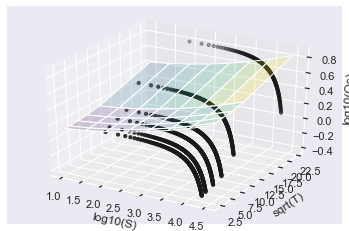

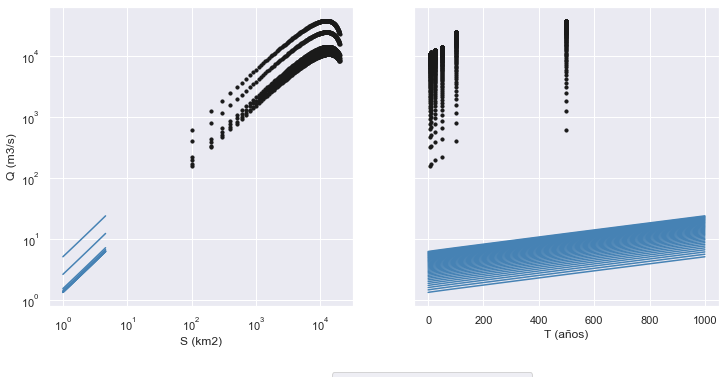

In [59]:
# plot points and fitted surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(YY, XX, ZZ, rstride=1, cstride=1,cmap='viridis', alpha=0.2, zorder=1)
ax.scatter(dataTransf['S'], dataTransf['T'], dataTransf['Qs'], c='k', s=10, zorder=2)
ax.set(xlabel='log10(S)', ylabel='sqrt(T)', zlabel='log10(Qs)')

fig, ax = plt.subplots(ncols=2, figsize=(12, 5.5), sharey=True)

for T in Qtragsa.columns:
    ax[0].plot(Qtragsa.index, Qtragsa[T], c='steelblue', label='ajuste TRAGSA', zorder=1)
for T in abaco.columns:
    ax[0].scatter(abaco.index, abaco[T] * abaco.index, s=10, c='k', label='abaco', zorder=2)
ax[0].set(xscale='log', yscale='log', xlabel='S (km2)', ylabel='Q (m3/s)')

for S in Qtragsa.index:
    ax[1].plot(Qtragsa.columns, Qtragsa.loc[S,:], c='steelblue', label='ajuste TRAGSA', zorder=1)
for S in abaco.index:    
    ax[1].scatter(abaco.columns, abaco.loc[S,:] * S, s=10, c='k', label='abaco', zorder=2)
ax[1].set(xscale='linear', yscale='log', xlabel='T (años)');
    
handles, labels = ax[1].get_legend_handles_labels()
labels = [labels[i] for i in [0, -1]]
handles = [handles[i] for i in [0, -1]]
fig.legend(handles, labels, loc=8, ncol=2, bbox_to_anchor=[0.35, -0.05, .3, .1]);

In [60]:
QfromTS(100, 100, pars)

185.13142373936074

In [62]:
S, Tabaco = 100, 500
Q = abaco.loc[S, Tabaco] * S
print('Abaco:\tT = {0:.1f} años'.format(Tabaco))

# calcular retorno según la fórmula de la CHC
def fCHC(T, S=S, Q=Q, a=3.5465, b=0.208, c=0.7727, d=-0.0315):
    return a * T**b * S**(c + d * np.log10(T)) - Q
Tchc = optimize.root_scalar(fCHC, bracket=[0.001, 5000], method='brentq').root
print('CHC:\tT = {0:.1f} años'.format(Tchc))

# calcular el retorno con el nuevo ajuste
Ttragsa = TfromSQ(S, Q, pars)
print('TRAGSA:\tT = {0:.1f} años'.format(Ttragsa))

Abaco:	T = 500.0 años


ValueError: f(a) and f(b) must have different signs

In [ ]:
rendCHC = pd.DataFrame(index=abaco.index, columns=abaco.columns)
rendTRAGSA = rendCHC.copy()
for S in abaco.index:
    for T in abaco.columns:
        print('S = {0:<5}\tT = {1:<3}'.format(S, T), end='\r')
        
        Q = abaco.loc[S, T] * S
        
        # calcular retorno según la fórmula de la CHC
        def fCHC(T, S=S, Q=Q, a=3.5465, b=0.208, c=0.7727, d=-0.0315):
            return a * T**b * S**(c + d * np.log10(T)) - Q
        Tchc = optimize.root_scalar(fCHC, bracket=[0.001, 50000], method='brentq').root
        rendCHC.loc[S,T] = abs(Tchc - T) / T

        # calcular el retorno con el nuevo ajuste
        Ttragsa = TfromSQ(S, Q, pars)
        rendTRAGSA.loc[S,T] = abs(Ttragsa - T) / T

In [ ]:
fig, ax = plt.subplots(ncols=2, sharey=True)
vmin, vmax = 0, 2
sns.heatmap(rendCHC.astype(float), vmin=vmin, vmax=vmax, cmap='viridis', square=True, ax=ax[0], cbar=False)
ax[0].set_title('CHC')
ax[0].set_xlabel('T')
im = sns.heatmap(rendTRAGSA.astype(float), vmin=vmin, vmax=vmax, cmap='viridis', square=True, ax=ax[1], cbar=False)
ax[1].set_title('TRAGSA')
ax[1].set_xlabel('T')

fig.text(.5, .96, 'Error absoluto relativo', fontsize=14, fontweight='bold', horizontalalignment='center');

En los mapas de calor anteriores se muestra el error absoluto relativo en el cálculo del periodo de retorno. Se comparan los resultados con el ajuste de la Confederación y el aquí hecho.

El ajuste de la Confederación es mejor para periodos de retorno bajos (colores más fríos), pero falla completamente para el periodo de retorno de 500 años (en amarillo). Por el contrario, el ajuste aquí hecho funciona muy bien en el periodo de retorno de 500 años, pero, sin ser malo, es peor que el ajuste de la Confederación para el resto de periodos de retorno.

```Python
def fTRAGSA(T, S=S, Q=Q, pars=pars, deg=1):
    """Función del caudal específico, superficie """
    
    # transformar los datos brutos
    Strans = np.log10(S)
    Ttrans = np.sqrt(T)
    Qtrans = np.log10(Q/S)
    
    if deg == 1:
        if len(pars) != 3:
            return print('ERROR. Número de parámetros erróneos.')
        a, b, c = pars
        return a * Ttrans + b * Strans + c - Qtrans
    
    if deg == 2:
        if len(pars) != 6:
            return print('ERROR. Número de parámetros erróneos.')
        a, b, c, d, e, f = pars
        return a + b * Ttrans + c * Strans + d * Ttrans * Strans + e * Ttrans**2 + f * Strans**2 - Qtrans


def fTRAGSAprime(T, S=S, pars=pars, deg=1):
    """
    """
    
    if deg == 1:
        if len(pars) != 3:
            return print('ERROR. Número de parámetros erróneos.')
        a, b, c = pars
        return a
    
    if deg == 2:
        if len(pars) != 6:
            return print('ERROR. Número de parámetros erróneos.')
        a, b, c, d, e, f = pars
        Strans = np.log10(S)
        Ttrans = np.sqrt(T)
        return b + d * Strans + 2 * e * Ttrans

# calcular retorno por el método de Brent
Tbrent = optimize.root_scalar(fTRAGSA, bracket=[.000001, 500], method='brentq').root
print('Brent:\tT = {0:.1f} años'.format(Tbrent))

# calcular retorno por el método de Newton
Tnewton = optimize.root_scalar(fTRAGSA, x0=100, fprime=fTRAGSAprime, method='newton').root
print('Newton:\tT = {0:.1f} años'.format(Tnewton))
```